# Metadata and database initialisation

## How to run docker-compose to setup docker envionment
Go to `crop-mask/production/dea_ml` folder and run 
```bash
docker-compose up
```
to start the docker dev environment. Then, in other terminal window run 
```bash
docker exec -it dea_ml_stats_1 /bin/bash
```

## open datacube dev environment setup

The original doc of [db_setup](https://datacube-core.readthedocs.io/en/latest/ops/db_setup.html).

In project root run ```docker-compose up```. Three containers will be created.

- postgresql, the database for the 
- localstack
- stats

1. ```createdb datacube```
   or
   ```createdb -h <hostname> -U <username> datacube```

2. ```datacube -v system init```
  After the datacube system initialisation, we can have the database with the following structure
  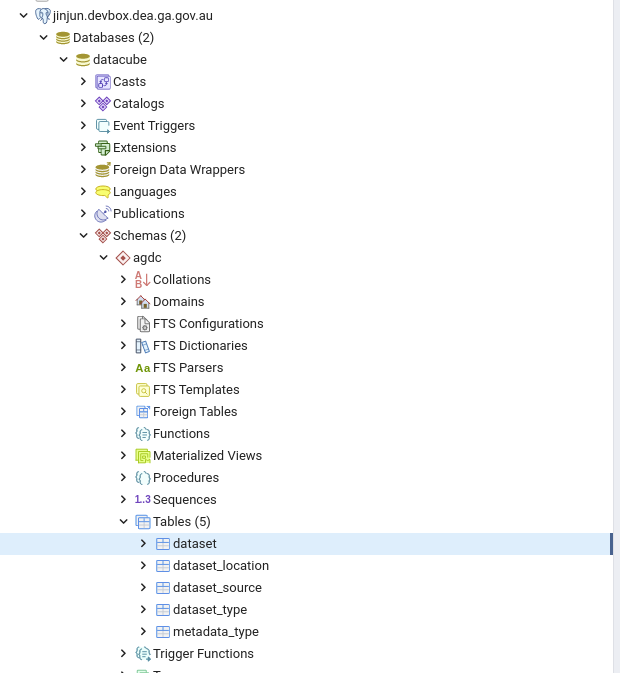
  <!--- <img src="../figs/datacube-steps/create_db_sys_init.png"> --->

3. Python class ```Datacube``` will look for a configuration file in `````~/.datacube.conf`````
which will be edited like sample below

```bash
[datacube]
 db_hostname: localhost
 db_username: postgres
 db_password: opendatacubepassword
```

4. prepare the product meta yaml file and add product into datacube

```bash
datacube product add <product_name>.odc-product.yaml
```
We will have the product meta row in the `dataset_type` table of `agdc` schema inside the `datacube` database.

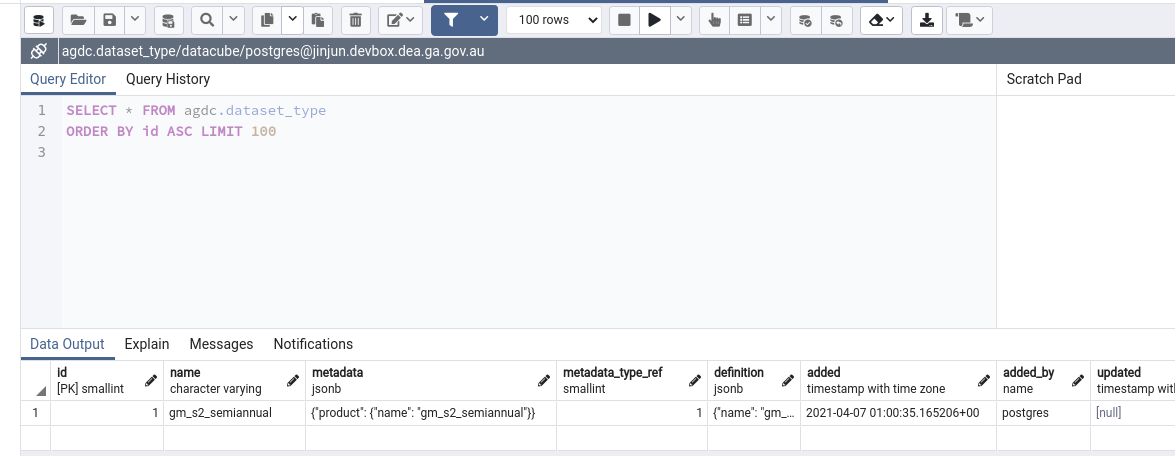


### Notes
The product yaml will has following fields. And the `metadata` will be picked up as the signature in the code. All the products definition can be found in the [config](https://github.com/digitalearthafrica/config) repo.

The follow is the `crop_mask` product yaml.

```yaml
---
name: crop_mask_eastern
description: Estern Africa region crop mask prediction based on features
   of s2_l2a statistics gm_tmad, plus NDVI, LAI, MNDWI, rainfall, slope
metadata_type: eo3

license: CC-BY-4.0

metadata:
   product:
      name: crop_mask_eastern

storage:
   crs: epsg:6933
   resolution:
      x: 20
      y: -20
   tile_size:
      x: 96000
      y: 96000

measurements:
   - name: mask
     aliases: ['crop_mask', 'MASK']
     dtype: uint8
     nodata: 255
     units: '1'

   - name: prob
     aliases: ['crop_prob', 'PROB']
     dtype: uint8
     nodata: 255
     units: '1'
```
